# Stratification (in MITgcm)
*Pressure, density, and buoyancy frequency in MITgcm*

Rowan Brown | 17.02.2025

I'm making this notebook as a reference for how to calculate pressure ($p$), density ($\rho$), and buoyancy frequency ($N^2$) from the MITgcm binary output.

But first, some necessary imports:

In [ ]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
from xmitgcm import open_mdsdataset 
from MITgcmutils import density
import basic_model_anayses as bma
import xgcm
import os

## Buoyancy frequency ($N^2$) and density ($\rho$)

Stratification is generally expressed in terms of buoyancy frequency, 
$$
    N^2= - \frac{g}{\rho} \frac{\partial \rho_{\theta}(z)}{\partial z},
$$
where $\rho$ is the in-situ (I think) density of a water parcel and $\partial \rho_{\theta}(z)/\partial z$ is the gradient of potential density.

If you have the coefficients of thermal and haline expansion, $\alpha$ and $\beta$, you can then express buoyancy frequency exactly using 
$$
    N^2 = g \left(\alpha \theta_z - \beta S_z \right),
$$ 
where $S$ is (practical) salinity and $\theta$ is potential temperature. 

It is therefore relatively simple, when using *eosType=LINEAR*, to calculate buoyancy frequency, because $\alpha$, $\beta$, and $\theta$ are given directly in either *data* or the model output. 

Note that you can consider $\theta_z$ to have two components, with one relating to the gradient of in-situ temperature and the other (much smaller component) relating to adiabatic and isentropic effects. See McDougall (1987; Netral Surfaces) and McDougall (1987; Thermobaricity...) for more.

### Linear EOS

With the *eosType=LINEAR*, vertical gradients are not only determined by the output profiles, but also by the reference profiles, i.e.,
$$
    \rho = \rho_0 \left( 1 - \alpha \left( T(z) - T_{ref}(z) \right) + \beta \left( S(z)-S_{ref}(z) \right) \right),
$$
and if we let $\beta=0$ then
$$
    \frac{\partial \rho}{\partial z} = - \rho_0 \alpha \left( \frac{\partial T }{ \partial z} - \frac{\partial T_{ref} }{ \partial z} \right)
$$
(where $\rho_0$ is *I think* also specified in *data* and I *also* think $T$ in this case relates to potential temperature). Since the reference temperature profile is often invariant, its gradient is 0 and we can neglect this term when calculating gradients.

Note the reason I let $\beta=0$ is that, in some of the MITgcm test cases like "deep convection", *sBeta=0* and *saltStepping=False*. This works because, when *sBeta=0*, salinity does not affect the density gradient and so *saltStepping* can be turned on/off like a pasive tracer. In this case, buoyancy is therefore set up by potential temperature alone, i.e., $N^2=g \alpha \theta_z$, and it is simple to calculate.

### Non-linear EOS

In the case of a non-linear EOS, such as *eosType=TEOS10*, calculating density and buoyancy frequency are more tricky. The crux is how to calculate pressure. Martin explains the general theory nicely here http://mailman.mitgcm.org/pipermail/mitgcm-support/2016-August/010541.html. For simplicity, the linearised equation $\partial p/\partial z = -g \rho_0$ is adequate. But in my simulations, I use the diagnostic package to output enough data so that I can calculate the pressure during post-processing. And, once we have pressure, we can use for example the Gibbs SeaWater (gsw) toolbox to calculate things like density (using TEOS10) and buoyancy frequency.

### Calculating pressure

To calculate pressure (with *Z*-coordinates), use
$$
    P_{sea\ water}(i,j,k)/ \rho_0 = -g\ rC(k) + PH(i,j,k) + PNH(i,j,k),
$$
where where $rC(k)$ is the depth at level $k$, and the reference hydrostatic pressure is simply $-g\ rC(k)$. $PH(i,j,k)$ and $PNH(i,j,k)$ are directly from the model and relate to the *Hydrostatic Pressure Pot.(p/rho) Anomaly* and the *Non-Hydrostatic Pressure Pot.(p/rho)*. 

Jody Klymack emphasizes, for *eosType=LINEAR*, that the hydrostatic pressure potential anomaly is
$$
    PH(i,j,k) \rho_0 = g \int_z^{\eta} \left( \rho(i,j,k) - \rho_r(k) \right) dz,
$$
where $\rho_r(k)$ is constant in depth if $T_{ref}$ is constant but varies if $T_{ref}$ is a profile. It can be obtained by the linear EOS if needed. His point is that the hydrostatic pressure is therefore
$$
    P_{hydrostatic} (i,j,k) = PH(i,j,k) \rho_0 + g \int_z^{\eta} \left( \rho_0 + \rho_r(k) \right) dz.
$$
Ultimately, then, the difference between this equation and the hydrostatic part of the earlier $P_{sea\ water}$ equation is the additional $\rho_r(k)$ term, which is apparently removed from $PH$ in the LINEAR case. He writes: "This doesn't seem consistent with the other equations fo state, but a lot of internal wave folks use linear equation of state, so its something to bear in mind.  However, this term has no physical dynamics either, so, can be dropped." 

Personally, I'm not sure that my clone of the model code works this way.

For more on pressure, see http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-August/008448.html, http://mailman.mitgcm.org/pipermail/mitgcm-support/2013-November/008636.html, and https://gist.github.com/jklymak/156c30b5344a9cf63e8aebc429fee1c6. 

## Calculating (hydrostatic) pressure with a non-linear EOS

*Hydrostatic* because I can't seem to open $PNH$.

In [1]:
data_dir = '../MITgcm/so_plumes/mrb_023/' # This is an example run with eosType=TEOS10
ds = bma.open_mitgcm_output_all_vars(data_dir)
g, rho_0 = 10, 1000 # From the mrb_023 data file
ds['p_lin'] = (-1)*g*rho_0*ds['Z']
ds['p_PH'] = (-1)*g*rho_0*ds['Z'] + ds['PH']*rho_0 

print(ds['p_lin'].values)
print(ds['p_PH'].isel(time=10,YC=50,XC=50).values)
print(ds['p_PH'].isel(time=300,YC=35,XC=75).values)

fig, ax = plt.subplots(figsize=(5,5)) # Initialise the figure
ds['p_lin'].plot(y='Z',label='Linearised',ax=ax,lw=4, ls='--')
ds['p_PH'].isel(time=10,YC=50,XC=50).plot(y='Z',label='PH 1',ax=ax)
ds['p_PH'].isel(time=300,YC=35,XC=75).plot(y='Z',label='PH 2',ax=ax)

ax.set_title('Pressure')
ax.set_xlabel('Hydrostatic pressure (units)')
ax.set_ylabel('Depth ($m$)')
plt.legend()


NameError: name 'bma' is not defined

[2.000e+03 1.000e+04 2.600e+04 5.000e+04 8.200e+04 1.220e+05 1.700e+05
 2.260e+05 2.900e+05 3.620e+05 4.420e+05 5.300e+05 6.260e+05 7.300e+05
 8.420e+05 9.620e+05 1.090e+06 1.226e+06 1.370e+06 1.522e+06 1.682e+06
 1.850e+06 2.026e+06 2.210e+06 2.402e+06 2.602e+06 2.810e+06 3.026e+06
 3.250e+06 3.482e+06 3.722e+06 3.970e+06 4.226e+06 4.490e+06 4.762e+06
 5.042e+06 5.330e+06 5.626e+06 5.930e+06 6.242e+06 6.562e+06 6.890e+06
 7.226e+06 7.570e+06 7.922e+06 8.282e+06 8.650e+06 9.026e+06 9.410e+06
 9.802e+06]
[1.8078861e+03 9.0394307e+03 2.3502521e+04 4.5197172e+04 7.4123406e+04
 1.1028129e+05 1.5367089e+05 2.0429230e+05 2.6214559e+05 3.2723069e+05
 3.9954759e+05 4.7909625e+05 5.6587644e+05 6.5988781e+05 7.6112938e+05
 8.6959919e+05 9.8529312e+05 1.1082069e+06 1.2383378e+06 1.3756855e+06
 1.5202515e+06 1.6720385e+06 1.8310486e+06 1.9972835e+06 2.1707445e+06
 2.3514325e+06 2.5393482e+06 2.7344920e+06 2.9368642e+06 3.1464652e+06
 3.3632950e+06 3.5873535e+06 3.8186410e+06 4.0571575e+06 4.302903

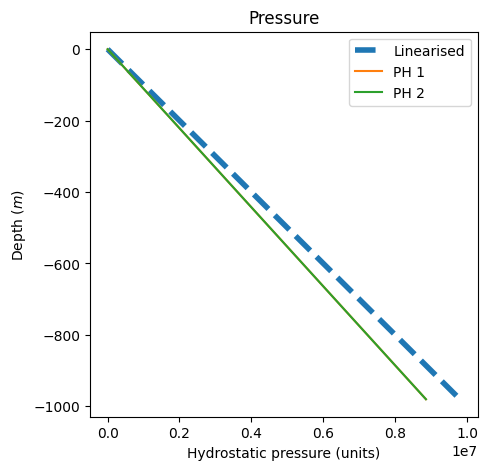

In [ ]:
data_dir = '../MITgcm/so_plumes/mrb_016/' # This is an example run with eosType=TEOS10
ds = bma.open_mitgcm_output_all_vars(data_dir)
g, rho_0, alpha = 10, 1000, 0.0002, # From the data file
ds['p_lin'] = (-1)*g*rho_0*ds['Z']
ds['p_PH'] = (-1)*g*rho_0*ds['Z'] + ds['PH']*rho_0 + rho_0*(1-alpha*(-20))*ds['Z']

print(ds['p_lin'].values)
print(ds['p_PH'].isel(time=10,YC=50,XC=50).values)
print(ds['p_PH'].isel(time=300,YC=35,XC=75).values)

fig, ax = plt.subplots(figsize=(5,5)) # Initialise the figure
ds['p_lin'].plot(y='Z',label='Linearised',ax=ax,lw=4, ls='--')
ds['p_PH'].isel(time=10,YC=50,XC=50).plot(y='Z',label='PH 1',ax=ax)
ds['p_PH'].isel(time=300,YC=35,XC=75).plot(y='Z',label='PH 2',ax=ax)

ax.set_title('Pressure')
ax.set_xlabel('Hydrostatic pressure (units)')
ax.set_ylabel('Depth ($m$)')
plt.legend()